In [19]:
import os
import sys
sys.path.append("../src/")
from FunctionalConnectivity import FunctionalConnectivity
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DDC=1
fig_dir='/home/acamassa/ABCD/DDC_figures/baseline'

In [3]:
if DDC:
    pickle_file_path = "/home/acamassa/ABCD/DDC_figures/baseline/two_hemi_fc_DDC.pkl"
    m="DDC"
else:
    pickle_file_path = "/home/acamassa/ABCD/DDC_figures/two_hemi_fc_Cov.pkl"
    m="Cov"
    
# Load the pickled object
with open(pickle_file_path, 'rb') as file:
    two_hemi_fc = pickle.load(file)

In [4]:
labels=pd.read_csv('/cnl/abcd/data/labels/baseline_depr_sex_age_hand.csv', index_col=0)
DDC_path = "/nadata/cnl/abcd/data/imaging/fmri/rsfmri/interim/DDC/baseline/"
fig_dir = "/home/acamassa/ABCD/DDC_figures/baseline/"


In [4]:
# # ## Two hemisphere FC
# two_hemi_fc = FunctionalConnectivity(
#     labels,
#     n_roi=98,
#     thrs=0.1,
#     weights_file_name="subc_DDC*.csv",
#     DDC_path=DDC_path,
#     fig_dir=fig_dir,
# )

In [5]:
# # # Save output
# pickle.dump(two_hemi_fc, open("/home/acamassa/ABCD/DDC_figures/baseline/two_hemi_fc_DDC.pkl", "wb"))

In [5]:
[ctrl_age, age] = two_hemi_fc.get_controls_age(labels=labels)

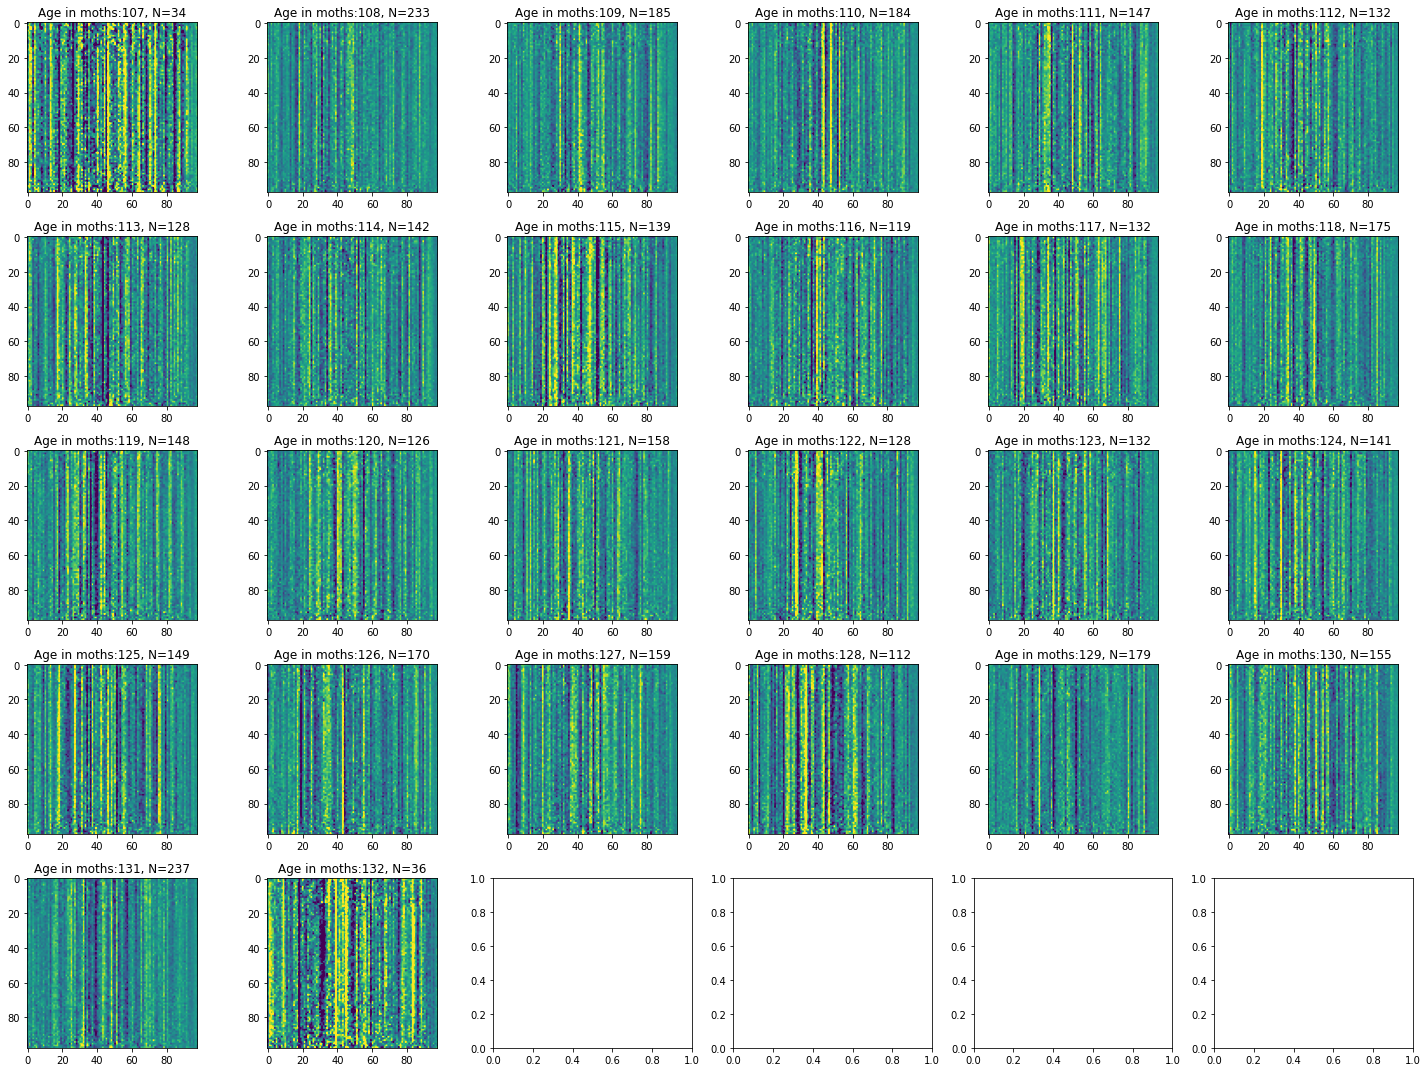

In [39]:
# Calculate average age
avg_age = [np.median(ctrl_age[i], axis=0) for i in range(len(ctrl_age))]

# Create subplots
fig, axs = plt.subplots(5, 6, figsize=(20, 15))

# Plot each average age in its corresponding subplot
for i in range(len(avg_age)):
    ax = axs[i // 6, i % 6]  # Calculate subplot index
    ax.imshow(avg_age[i], vmin=-20, vmax=20)
    ax.set_title('Age in moths:'+ str(age[i]) + ', N='+ str(len(ctrl_age[i])))

plt.tight_layout()
plt.show()

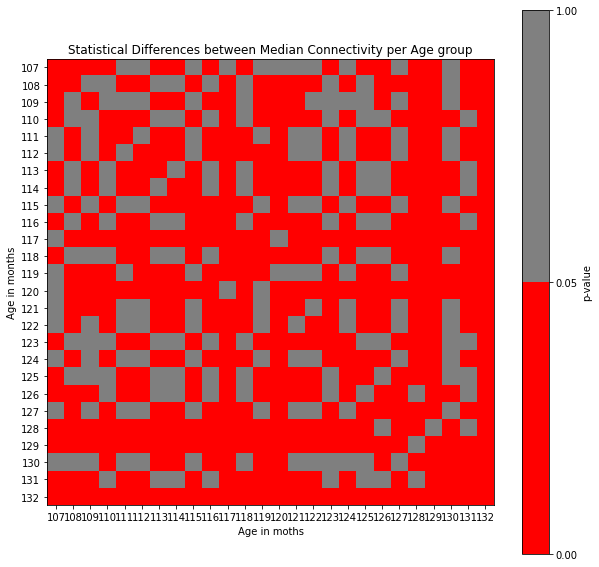

In [54]:
# Compute statistical differences between each pair of matrices
from scipy.stats import ttest_ind
import matplotlib.colors as mcolors

# Compute statistical differences between each pair of matrices
p_values = np.zeros((len(avg_age), len(avg_age)))
for i in range(len(avg_age)):
    for j in range(i + 1, len(avg_age)):
        _, p = ttest_ind(avg_age[i].flatten(), avg_age[j].flatten())
        p_values[i, j] = p
        p_values[j, i] = p  # Since t-test is symmetric, store in both positions

# Create custom colormap
colors = [ (1, 0, 0),(0.5, 0.5, 0.5)]  # Gray for non-significant, Red for p<0.05
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=256)
bounds = [0, 0.05, 1]  # Specify color boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot p-values matrix
plt.figure(figsize=(10,10))
plt.imshow(p_values, cmap=cmap, norm=norm)  # Set color scale to represent p-values
plt.colorbar(label='p-value')
plt.title('Statistical Differences between Median Connectivity per Age group')
plt.xlabel('Age in moths')
plt.ylabel('Age in months')
plt.xticks(range(len(age)), age)
plt.yticks(range(len(age)), age)
plt.show()

In [ ]:
# Calculate p-values for each i,j comparing ctrl_age[0] with all others
from scipy.stats import ks_2samp
p_values_matrices = []
for group in ctrl_age[1:]:
    p_values = np.zeros((ctrl_age[0][0].shape[0], ctrl_age[0][0].shape[1]))
    for i in range(ctrl_age[0][0].shape[0]):
        for j in range(ctrl_age[0][0].shape[1]):
            data0 = np.concatenate([ctrl_age[0][k][i, j].flatten() for k in range(len(ctrl_age[0]))])
            data1 = np.concatenate([group[k][i, j].flatten() for k in range(len(group))])
            _, p_values[i, j] = ks_2samp(data0, data1)
    p_values_matrices.append(p_values)


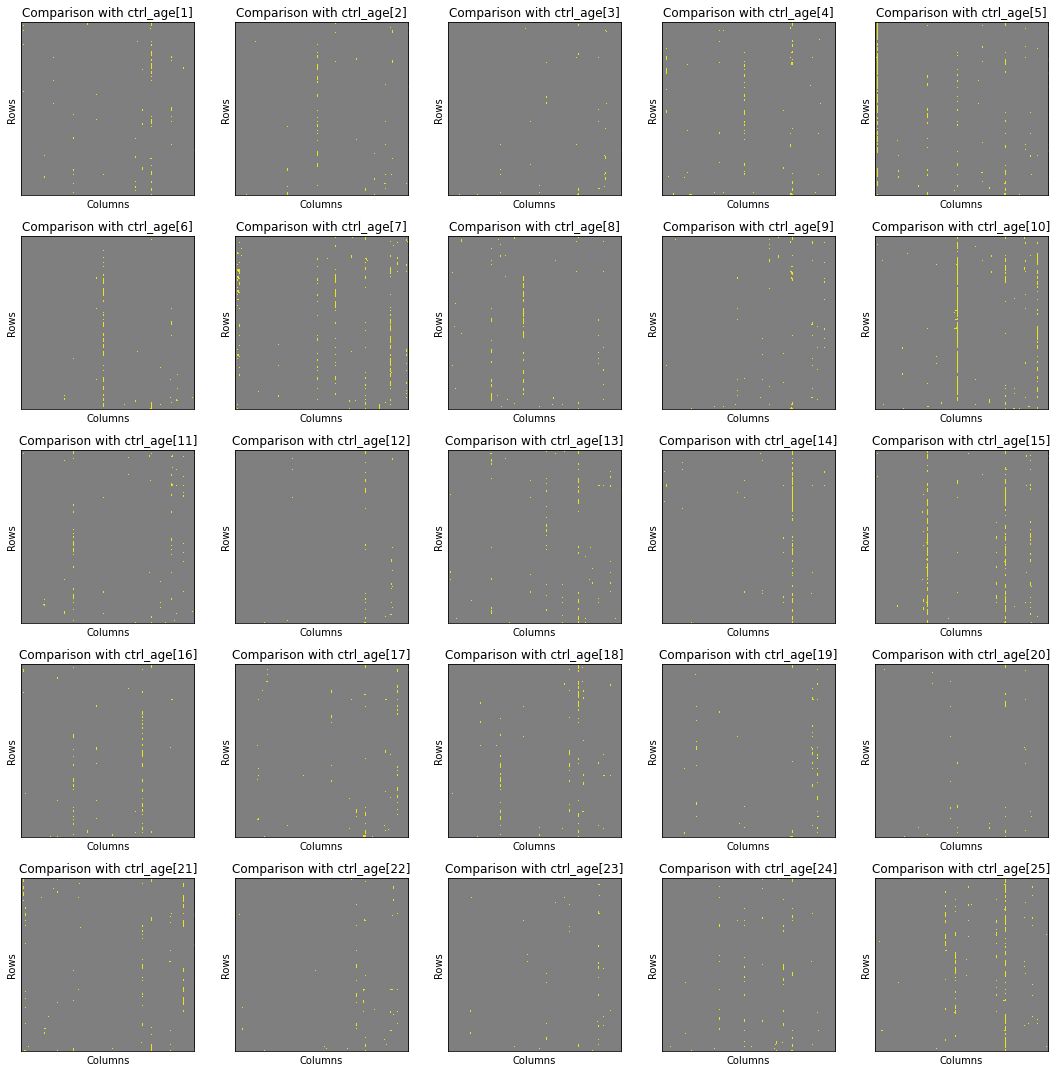

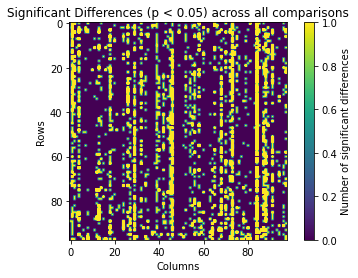

In [82]:
# Calculate p-values for each i,j comparing ctrl_age[0] with all others
# p_values_matrices = []
# for group in ctrl_age[1:]:
#     p_values = np.zeros((ctrl_age[0][0].shape[0], ctrl_age[0][0].shape[1]))
#     for i in range(ctrl_age[0][0].shape[0]):
#         for j in range(ctrl_age[0][0].shape[1]):
#             data0 = np.concatenate([ctrl_age[0][k][i, j].flatten() for k in range(len(ctrl_age[0]))])
#             data1 = np.concatenate([group[k][i, j].flatten() for k in range(len(group))])
#             _, p_values[i, j] = ks_2samp(data0, data1)
#     p_values_matrices.append(p_values)

# Plot all p-values matrices in subplots
n_groups = len(p_values_matrices)
n_cols = 5  # Number of columns in the subplot grid
n_rows = (n_groups - 1) // n_cols + 1  # Calculate the number of rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
for i, ax in enumerate(axes.flat):
    if i < n_groups:
        ax.imshow(p_values_matrices[i],  cmap=cmap, norm=norm)  # Set color scale to represent p-values
        ax.set_title(f'Comparison with ctrl_age[{i+1}]')
        ax.set_xlabel('Columns')
        ax.set_ylabel('Rows')
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')  # Hide empty subplots if there are fewer groups than subplots

plt.tight_layout()
plt.show()

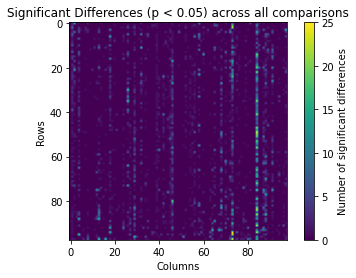

In [95]:
p_values_matrices_bin=[]
for i in range(np.shape(p_values_matrices)[0]):
    p_values_matrices_bin.append((p_values_matrices[i]<0.05)*1)
    
plt.imshow(np.sum(p_values_matrices_bin, axis=0))

plt.colorbar(label='Number of significant differences')
plt.title('Significant Differences (p < 0.05) across all comparisons')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [101]:
[control_M, control_F]=two_hemi_fc.get_controls_sex(labels=labels)
[control_R, control_L]=two_hemi_fc.get_controls_hand(labels=labels)

In [102]:
control=np.vstack((control_M, control_F))

In [6]:
# outliers detection here

In [103]:
# Remove undesired areas (3rd and 4th ventricles, csf)

# Indices of rows and columns to remove
rows_to_remove = [0,1,2,3,9, 10, 14,16,17,18,19,20]
columns_to_remove = [0,1,2,3,9, 10, 14,16,17,18,19,20]

# Remove specified rows and columns
filtered_matrix = np.delete(control, rows_to_remove, axis=1)
filtered_matrix = np.delete(filtered_matrix, columns_to_remove, axis=2)
print('All', np.shape(filtered_matrix))
control_M_filt = np.delete(control_M, rows_to_remove, axis=1)
control_M_filt = np.delete(control_M_filt, columns_to_remove, axis=2)
print('Males',np.shape(control_M_filt))
control_F_filt = np.delete(control_F, rows_to_remove, axis=1)
control_F_filt = np.delete(control_F_filt, columns_to_remove, axis=2)
print('Females',np.shape(control_F_filt))
control_R_filt = np.delete(control_R, rows_to_remove, axis=1)
control_R_filt = np.delete(control_R_filt, columns_to_remove, axis=2)
print('Right',np.shape(control_R_filt))
control_L_filt = np.delete(control_L, rows_to_remove, axis=1)
control_L_filt = np.delete(control_L_filt, columns_to_remove, axis=2)
print('Left',np.shape(control_L_filt))

All (3780, 86, 86)
Males (1474, 86, 86)
Females (2306, 86, 86)
Right (3410, 86, 86)
Left (370, 86, 86)


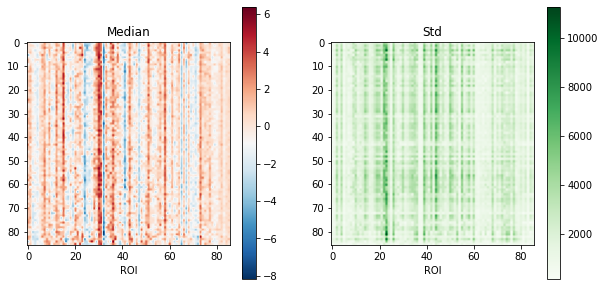

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.nanmedian(filtered_matrix, axis=0), cmap='RdBu_r')
plt.xlabel('ROI')
plt.xlabel('ROI')
plt.title('Median')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.nanstd(filtered_matrix, axis=0), cmap='Greens')
plt.colorbar()
plt.xlabel('ROI')
plt.xlabel('ROI')
plt.title('Std')
plt.savefig(fig_dir+"/Controls_Median_Std_{}.svg".format(m))

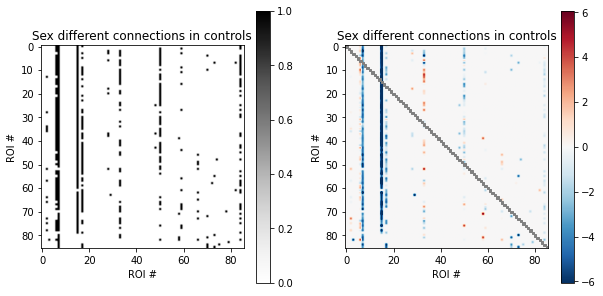

In [105]:
stat_diff_C, diff_C=two_hemi_fc.plot_significant_sex_diff(control_M_filt, control_F_filt, condition=[0,0], colorbar=True, save_as="Controls_sex_diff_{}.svg".format(m), bonferroni=False, median=1, ttest=0)

In [106]:
os.chdir('/home/acamassa/ABCD/DDC/src/abcd_ddc/')
# # Load the variable from the pickle file
with open('all_ROIsFC.pickle', 'rb') as f:
    all_ROIsFC = pickle.load(f)


results_df=pd.DataFrame(index=all_ROIsFC, columns=['increased in M','increased in F','increased in L', 'increased in R'])

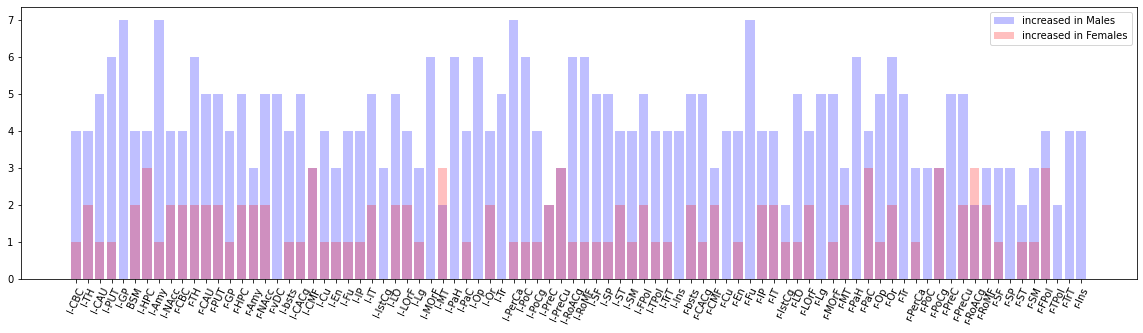

In [107]:
# the histograms shows how many connections from a certain area
# are stronger in males
# or females subjects

if DDC:
    l=list(np.where((diff_C)<0)[0])
else:
    l=list(np.where(np.tril(diff_C)<0)[0])

elements=np.unique(l)

xm=np.zeros(len(diff_C))
for ele in elements:
    xm[ele]=l.count(ele)

results_df['increased in M']=xm

fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x=np.arange(0,len(xm)), height=xm, color='b', alpha = 0.25, label='increased in Males')
ax.set_xticks(np.arange(0,len(xm)))

os.chdir('/home/acamassa/ABCD/DDC/src/abcd_ddc/')
# # Load the variable from the pickle file
with open('all_ROIsFC.pickle', 'rb') as f:
    all_ROIsFC = pickle.load(f)
ax.set_xticklabels(all_ROIsFC, rotation=65)


if DDC:
    l=list(np.where((diff_C)>0)[0])
else:
    l=list(np.where(np.tril(diff_C)>0)[0])

xf=np.zeros(len(diff_C))
elements=np.unique(l)
for ele in elements:
    xf[ele]=l.count(ele)

results_df['increased in F']=xf

ax.bar(x=np.arange(0,len(xf)), height=xf, color='r',  alpha = 0.25, label='increased in Females')
ax.set_xticks(np.arange(0,len(xf)))
# selected_strings = [all_ROIs[i] for i in elements]
ax.set_xticklabels(all_ROIsFC, rotation=65)
# ax.set_title('Areas with connectivity increased in Females')
plt.legend()
plt.savefig(fig_dir+"/Controls_Sex_Hist_{}.svg".format(m))

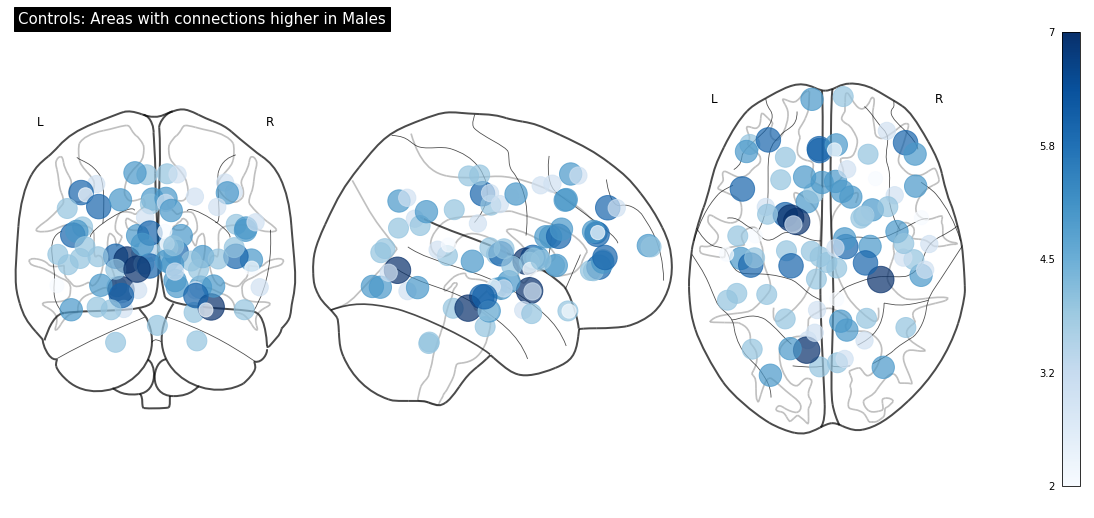

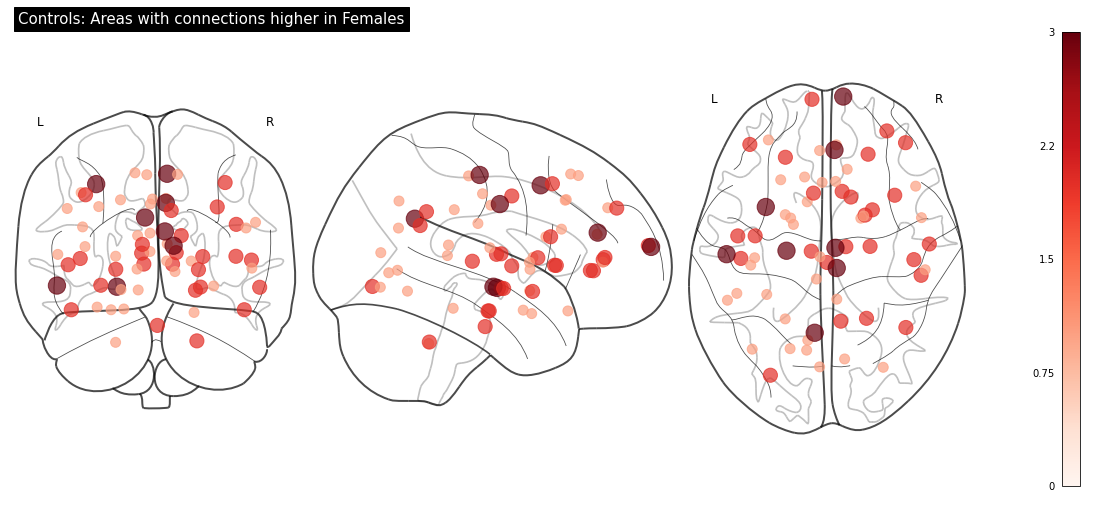

In [11]:
from nilearn import plotting
import numpy as np
import seaborn as sns

# Load the variable from the pickle file
os.chdir(fig_dir)
with open('coord_list.pickle', 'rb') as f:
    coord_list = pickle.load(f)

coord_list = np.delete(coord_list, rows_to_remove, axis=0)

fig1=plt.figure(figsize=(15,7))
plotting.plot_markers(
    xm,
    coord_list,
    node_cmap="Blues",
    figure=fig1,
    # node_vmin=-2e-18,
    # node_vmax=2e-18,
    node_size=xm*100,
    title="Controls: Areas with connections higher in Males",
)

fig2=plt.figure(figsize=(15,7))
plotting.plot_markers(
    xf,
    coord_list,
    node_cmap="Reds",
    figure=fig2,
    # node_vmin=-2e-18,
    # node_vmax=2e-18,
    node_size=xf*100,
    title="Controls: Areas with connections higher in Females",
)

/home/acamassa/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_projectors.py:190: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(


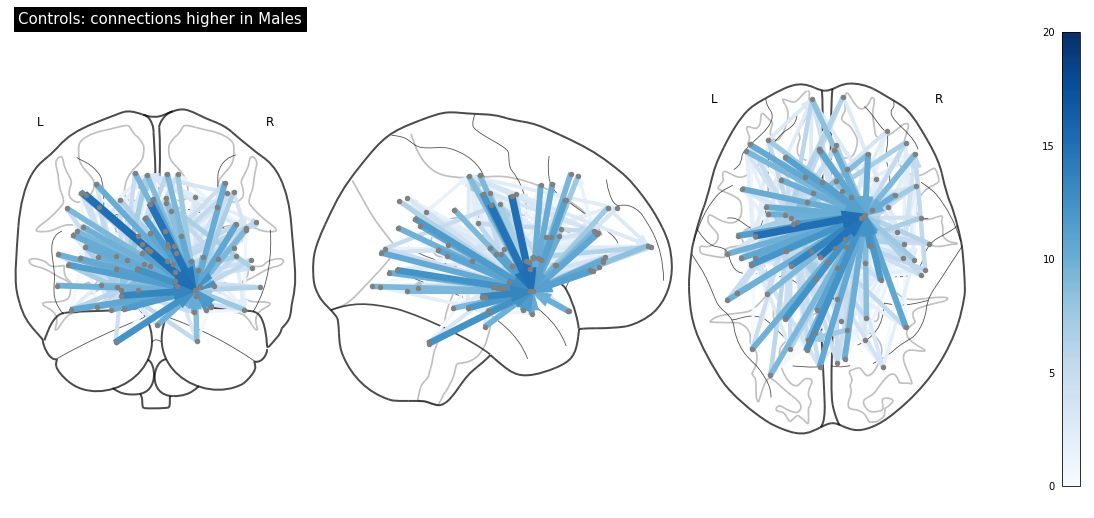

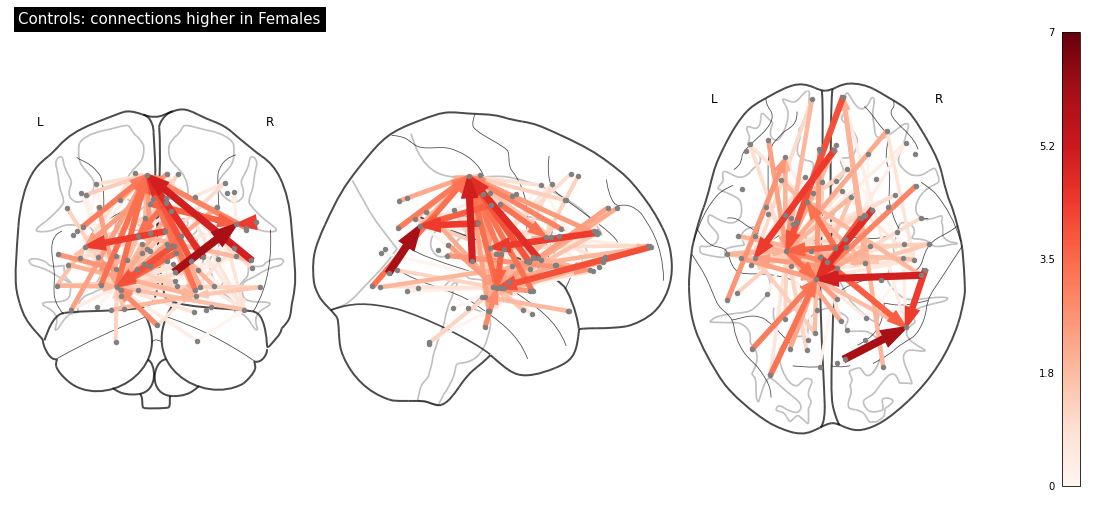

In [12]:
conn=np.zeros(np.shape(diff_C))
conn[np.where((diff_C)<0)]=diff_C[np.where((diff_C)<0)]

if DDC:
    ed=20
else:
    ed=1

fig=plt.figure(figsize=(15,7))
plotting.plot_connectome(
    abs(conn),
    coord_list,
    node_color='grey',
    edge_cmap="Blues",
    figure=fig,
    title="Controls: connections higher in Males",
    # edge_threshold="95%",
    node_size=20,
    colorbar=True,
    edge_vmin=0,
    edge_vmax=ed,
)

conn=np.zeros(np.shape(diff_C))
conn[np.where((diff_C)>0)]=diff_C[np.where((diff_C)>0)]

if DDC:
    ed=7
else:
    ed=1

fig=plt.figure(figsize=(15,7))
plotting.plot_connectome(
    abs(conn),
    coord_list,
    node_color='grey',
    edge_cmap="Reds",
    figure=fig,
    title="Controls: connections higher in Females",
    # edge_threshold="95%",
    node_size=20,
    colorbar=True,
    edge_vmin=0,
    edge_vmax=ed,
)

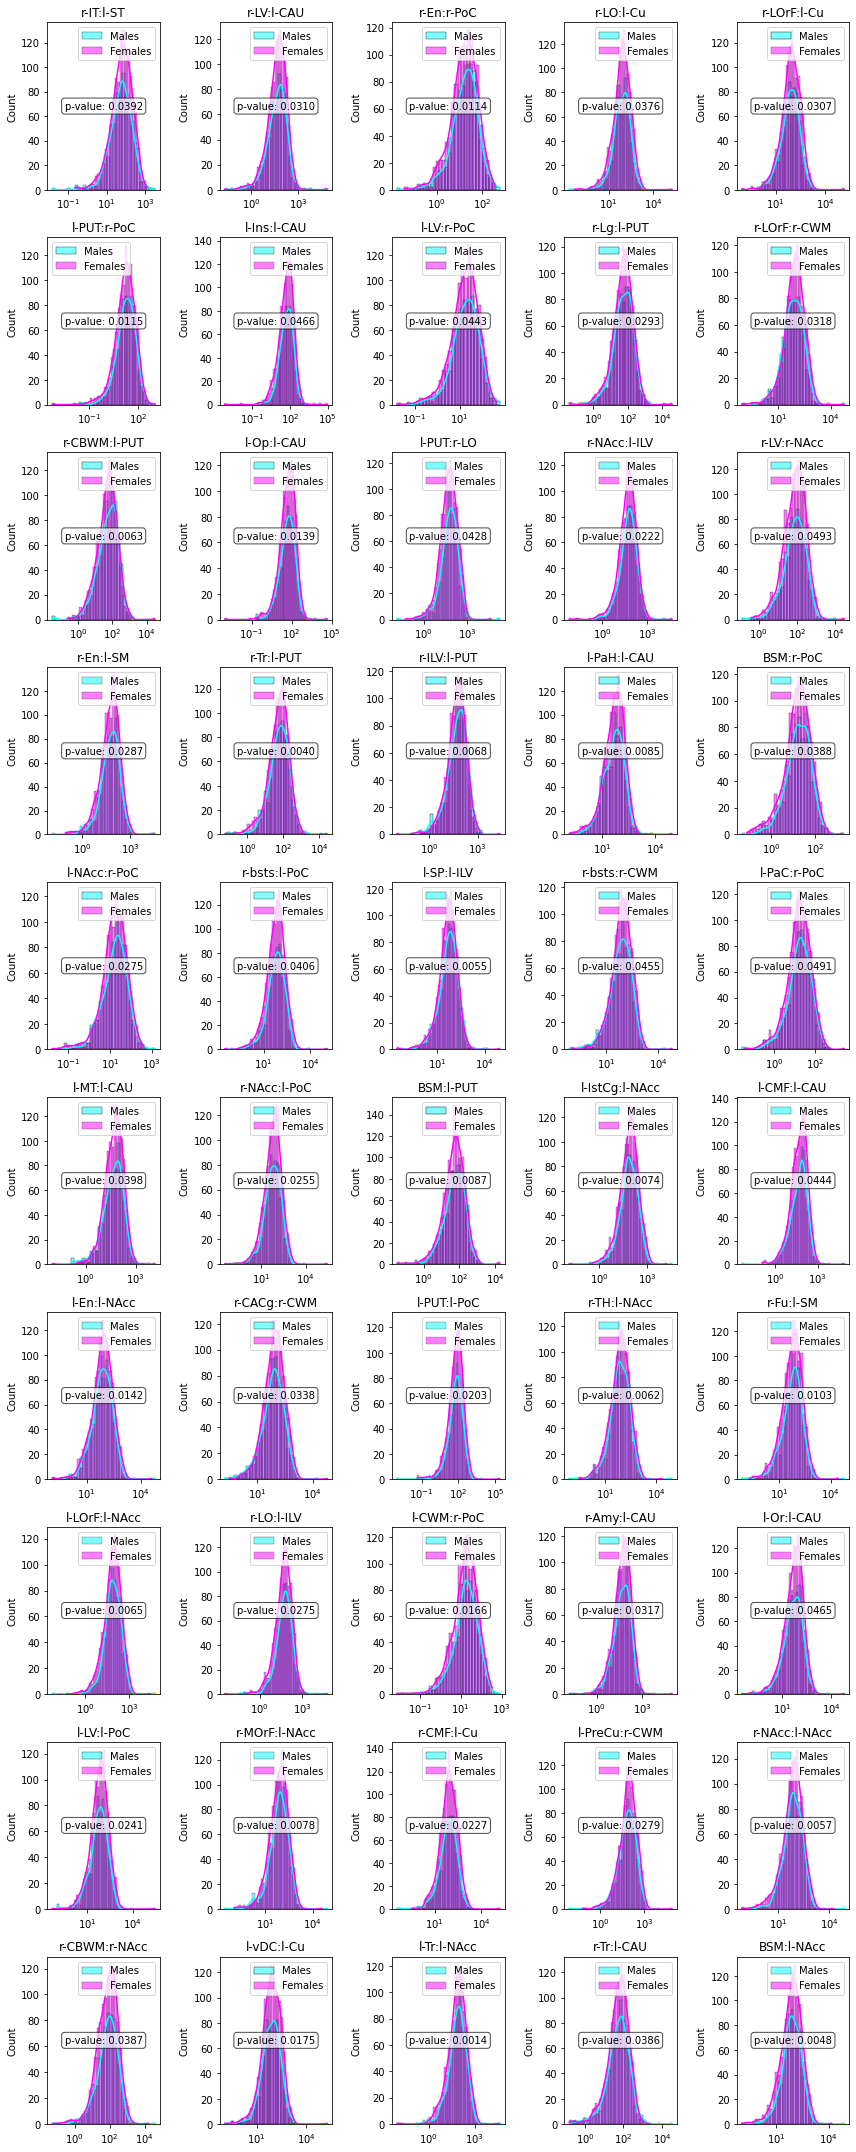

In [13]:
_=two_hemi_fc.plot_significant_sex_diff_distribution(stat_diff_C, control_M_filt, control_F_filt, ttest=0, log=1)

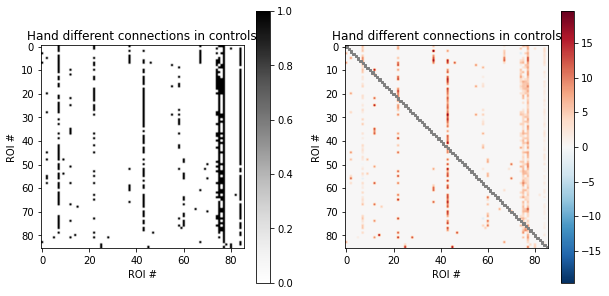

In [109]:
stat_diff_H, diff_H=two_hemi_fc.plot_significant_hand_diff(control_R_filt, control_L_filt, condition=[0,0], colorbar=True, save_as="Controls_hand_diff_{}.svg".format(m), bonferroni=False, median=1, ttest=0)

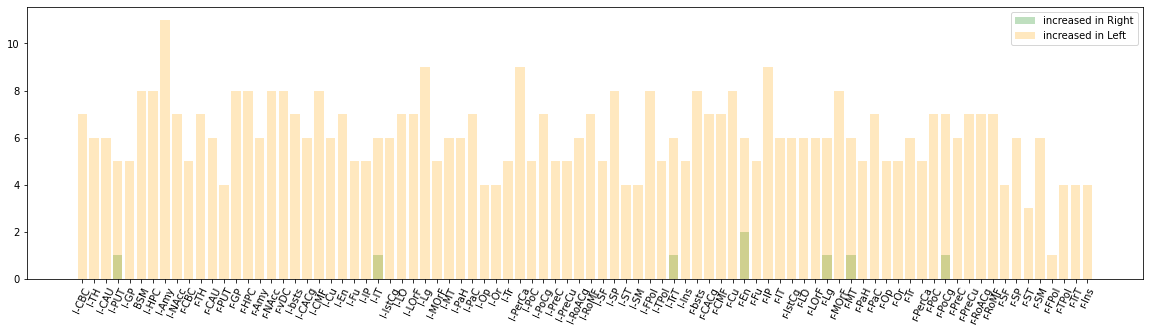

In [110]:
# the histograms shows how many connections from a certain area
# are stronger in right
# or left handed subjects

if DDC:
    l=list(np.where((diff_H)<0)[0])
else:
    l=list(np.where(np.tril(diff_H)<0)[0])

elements=np.unique(l)

xr=np.zeros(len(diff_H))
for ele in elements:
    xr[ele]=l.count(ele)

results_df['increased in R']=xr

fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x=np.arange(0,len(xr)), height=xr, color='green', alpha = 0.25, label='increased in Right')
ax.set_xticks(np.arange(0,len(xr)))

os.chdir('/home/acamassa/ABCD/DDC/src/abcd_ddc/')
# # Load the variable from the pickle file
with open('all_ROIsFC.pickle', 'rb') as f:
    all_ROIsFC = pickle.load(f)
ax.set_xticklabels(all_ROIsFC, rotation=65)

if DDC:
    l=list(np.where((diff_H)>0)[0])
else:
    l=list(np.where(np.tril(diff_H)>0)[0])

elements=np.unique(l)
xl=np.zeros(len(diff_H))
for ele in elements:
    xl[ele]=l.count(ele)

results_df['increased in L']=xl

ax.bar(x=np.arange(0,len(xl)), height=xl, color='orange',  alpha = 0.25, label='increased in Left')
ax.set_xticks(np.arange(0,len(xl)))
# selected_strings = [all_ROIs[i] for i in elements]
ax.set_xticklabels(all_ROIsFC, rotation=65)
# ax.set_title('Areas with connectivity increased in Females')
plt.legend()
plt.savefig(fig_dir+"/Controls_Hand_Hist_{}.svg".format(m))

In [112]:
results_df.to_csv('/home/acamassa/ABCD/DDC_figures/baseline/sex_hand_diff.csv')

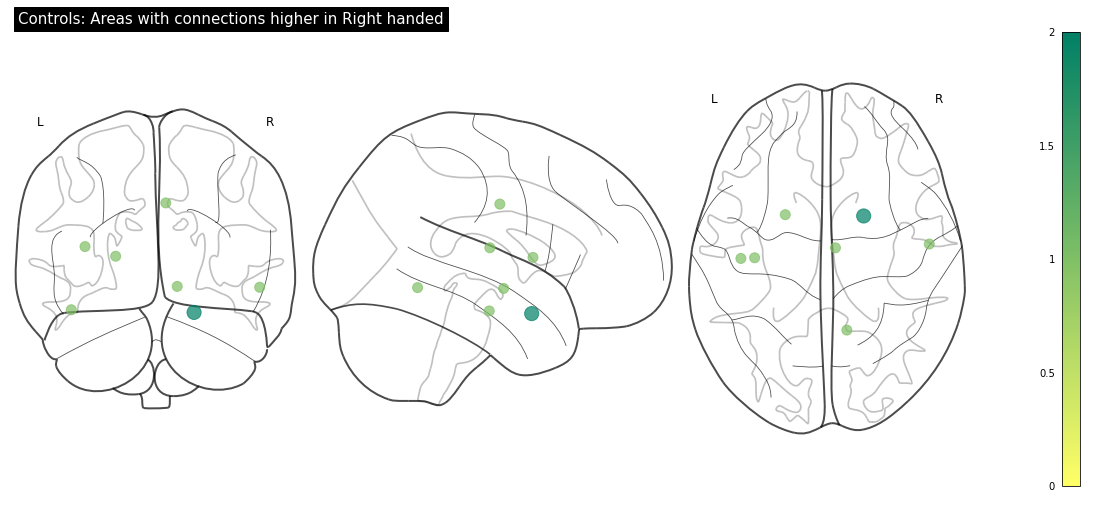

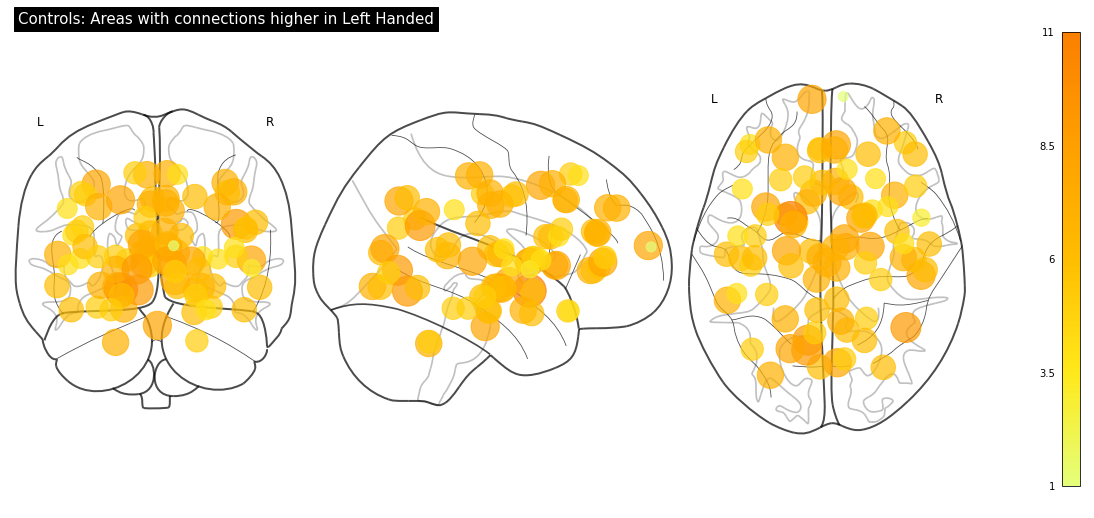

In [16]:
from nilearn import plotting
import numpy as np
import seaborn as sns

# Load the variable from the pickle file
os.chdir(fig_dir)
with open('coord_list.pickle', 'rb') as f:
    coord_list = pickle.load(f)

coord_list = np.delete(coord_list, rows_to_remove, axis=0)

fig1=plt.figure(figsize=(15,7))
plotting.plot_markers(
    xr,
    coord_list,
    node_cmap="summer_r",
    figure=fig1,
    # node_vmin=-2e-18,
    # node_vmax=2e-18,
    node_size=xr*100,
    title="Controls: Areas with connections higher in Right handed",
)

fig2=plt.figure(figsize=(15,7))
plotting.plot_markers(
    xl,
    coord_list,
    node_cmap="autumn_r",
    figure=fig2,
    # node_vmin=-2e-18,
    # node_vmax=2e-18,
    node_size=xl*100,
    title="Controls: Areas with connections higher in Left Handed",
)

/home/acamassa/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_projectors.py:190: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(


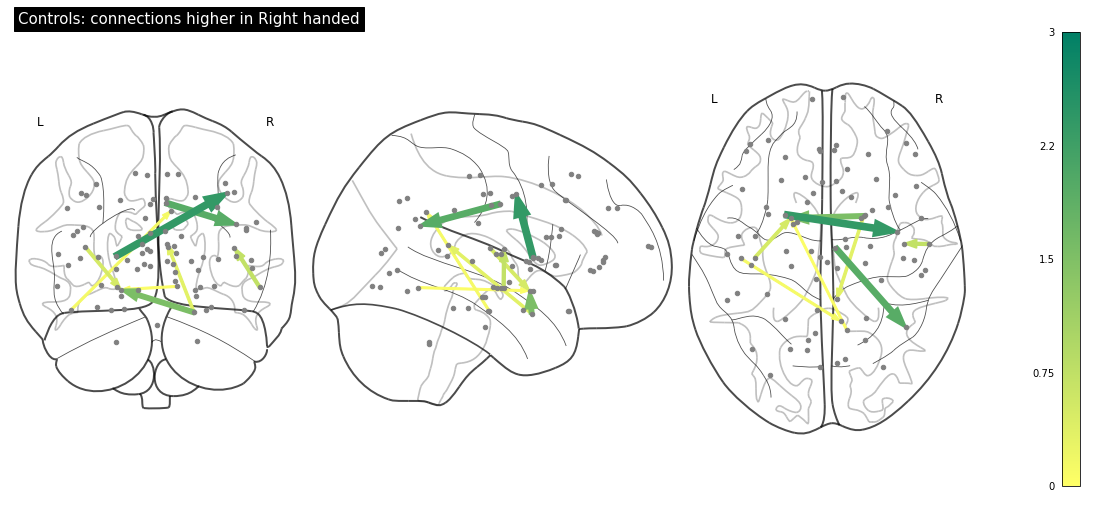

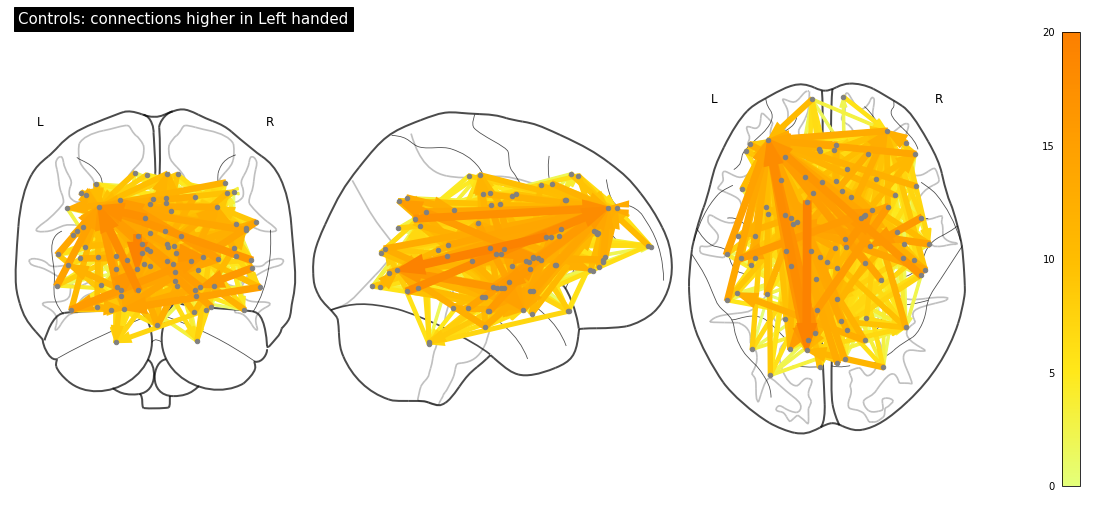

In [17]:
conn=np.zeros(np.shape(diff_H))
conn[np.where((diff_H)<0)]=diff_H[np.where((diff_H)<0)]

fig=plt.figure(figsize=(15,7))
plotting.plot_connectome(
    abs(conn),
    coord_list,
    node_color='grey',
    edge_cmap="summer_r",
    figure=fig,
    title="Controls: connections higher in Right handed",
    # edge_threshold="95%",
    node_size=20,
    colorbar=True,
    edge_vmin=0,
    edge_vmax=3,
)

conn=np.zeros(np.shape(diff_H))
conn[np.where((diff_H)>0)]=diff_H[np.where((diff_H)>0)]

fig=plt.figure(figsize=(15,7))
plotting.plot_connectome(
    conn,
    coord_list,
    node_color='grey',
    edge_cmap="Wistia",
    figure=fig,
    title="Controls: connections higher in Left handed",
    # edge_threshold="99%",
    node_size=20,
    colorbar=True,
    edge_vmin=0,
    edge_vmax=20,
)

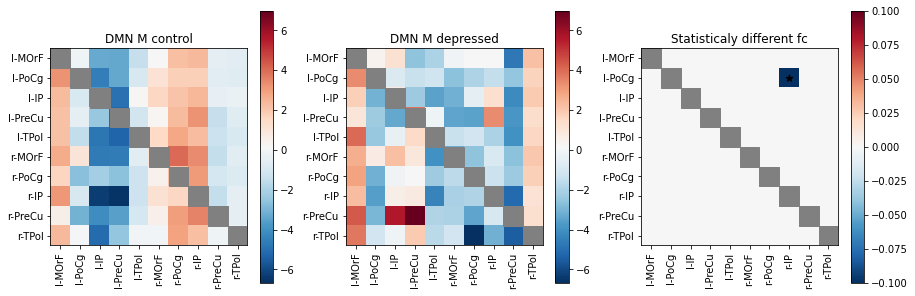

In [18]:
two_hemi_fc.plot_network_heatmap_sex(control_M, control_F, 'DMN', sex='M', save_as="DMN_Controls_Sex_{}.svg".format(m), bonferroni=False, scaling=0, ttest=0, median=1)

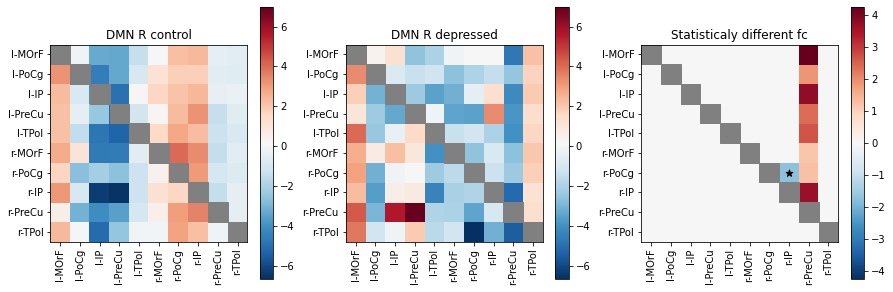

In [19]:
two_hemi_fc.plot_network_heatmap_hand(control_R, control_L, 'DMN', hand='R', save_as="DMN_Controls_Hand_{}.svg".format(m), bonferroni=False, ttest=0, median=1)

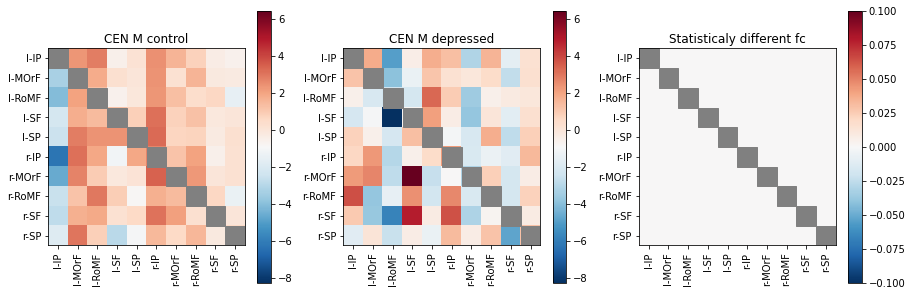

In [20]:
two_hemi_fc.plot_network_heatmap_sex(control_M, control_F, 'CEN', sex='M', save_as="CEN_Controls_Sex_{}.svg".format(m), bonferroni=False, scaling=0, ttest=0, median=1)

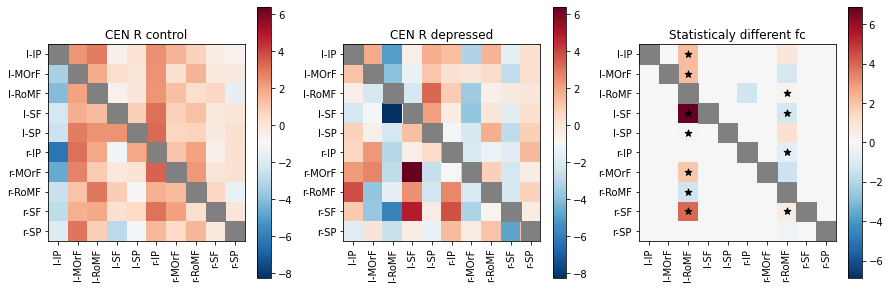

In [21]:
two_hemi_fc.plot_network_heatmap_hand(control_R, control_L, 'CEN', hand='R', save_as="CEN_Controls_Hand_{}.svg".format(m), bonferroni=False, ttest=0, median=1)

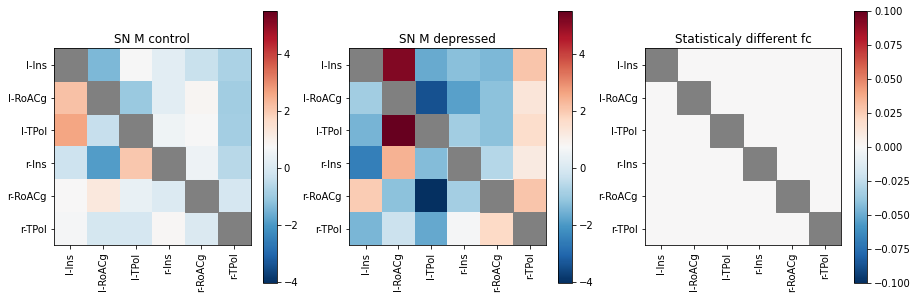

In [22]:
two_hemi_fc.plot_network_heatmap_sex(control_M, control_F, 'SN', sex='M', save_as="SN_Controls_Sex_{}.svg".format(m), bonferroni=False, scaling=0, ttest=0, median=1)

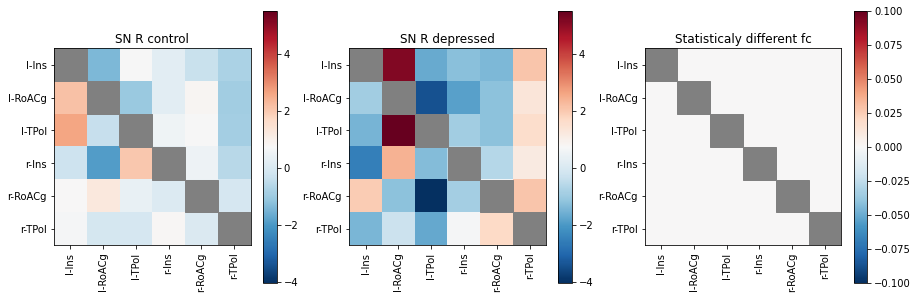

In [23]:
two_hemi_fc.plot_network_heatmap_hand(control_R, control_L, 'SN', hand='R', save_as="SN_Controls_Hand_{}.svg".format(m), bonferroni=False, ttest=0, median=1)

In [24]:
from pycirclize import Circos
import pandas as pd
import numpy as np


row_names = all_ROIsFC
col_names = row_names
R=np.nanmedian(control_M_filt, axis=0)
matrix=R


percentile_value = np.percentile(np.abs(matrix), 99)

filtered_matrix = np.where(np.abs(matrix) < percentile_value, 1, matrix)
matrix_df = pd.DataFrame(np.round(abs(filtered_matrix)), index=row_names, columns=col_names)


circos = Circos.initialize_from_matrix(
    matrix_df,
    space=1,
    cmap="tab10",
    label_kws=dict(r=94, size=8, ),
)

circos.savefig(fig_dir+"Controls_M_{}.png".format(m))


In [25]:
row_names = all_ROIsFC
col_names = row_names
R=np.nanmedian(control_F_filt, axis=0)
matrix=R


percentile_value = np.percentile(np.abs(matrix), 99)

filtered_matrix = np.where(np.abs(matrix) < percentile_value, 1, matrix)
matrix_df = pd.DataFrame(np.round(abs(filtered_matrix)), index=row_names, columns=col_names)


circos = Circos.initialize_from_matrix(
    matrix_df,
    space=1,
    cmap="tab10",
    label_kws=dict(r=94, size=8, ),
)

circos.savefig(fig_dir+"/Controls_F_{}.png".format(m))

In [26]:
row_names = all_ROIsFC
col_names = row_names
R=np.nanmedian(control_R_filt, axis=0)
matrix=R

percentile_value = np.percentile(np.abs(matrix), 99)


filtered_matrix = np.where(np.abs(matrix) < percentile_value, 1, matrix)
matrix_df = pd.DataFrame(np.round(abs(filtered_matrix)), index=row_names, columns=col_names)


circos = Circos.initialize_from_matrix(
    matrix_df,
    space=1,
    cmap="tab10",
    label_kws=dict(r=94, size=8, ),
)

circos.savefig(fig_dir+"Controls_R_{}.png".format(m))

In [27]:
from pycirclize import Circos
import pandas as pd
import numpy as np


row_names = all_ROIsFC
col_names = row_names
R=np.nanmedian(control_L_filt, axis=0)
matrix=R

# Calculate the 99th percentile value
percentile_value = np.percentile(np.abs(matrix), 99)

# Set values below the 99th percentile to 0
filtered_matrix = np.where(np.abs(matrix) < percentile_value, 1, matrix)
matrix_df = pd.DataFrame(np.round(abs(filtered_matrix)), index=row_names, columns=col_names)


circos = Circos.initialize_from_matrix(
    matrix_df,
    space=1,
    cmap="tab10",
    label_kws=dict(r=94, size=8, ),
)

circos.savefig(fig_dir+"Controls_L_{}.png".format(m))

In [28]:
two_hemi_fc.plot_connection_probDistr2(x='r-PreCu', y='l-IP')

AttributeError: 'FunctionalConnectivity' object has no attribute 'plot_connection_probDistr2'